## Wave function

$$\psi(x) = A e^{-\frac{x^2}{2\sigma^2}} \cos(kx+\alpha\epsilon)$$


$$\epsilon \in \mathcal{N}(0,1)$$

In [11]:
import psutil
import torch

# Get the number of logical CPUs (threads)
num_threads = psutil.cpu_count(logical=True)
print(f"Number of threads: {num_threads}")
torch.set_num_threads(16)
current_threads = torch.get_num_threads()
print(f"PyTorch is using {current_threads} threads.")

Number of threads: 16
PyTorch is using 16 threads.


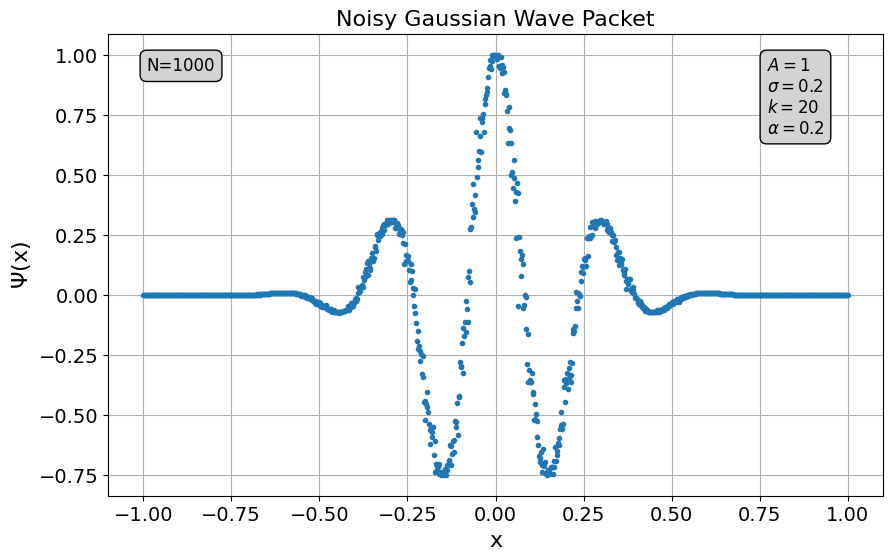

In [44]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Seed for reproducibility
torch.manual_seed(123)

# Step 1: Define the wave function with noise in PyTorch
def noisy_gaussian_wave_function(x, k=1, sigma=1, A=1):
    """Generates a Gaussian wave packet with added noise epsilon ~ N(0,1)."""
    epsilon = torch.normal(mean=0.0, std=1.0, size=x.shape)  # Generate noise (epsilon) from N(0,1)
    return A * torch.exp(-((x+0.005*epsilon)**2) / (2 * sigma**2)) * torch.cos(k * x + epsilon * 0.1)

# Parameters
A = 1
sigma = 0.2
k = 20
alpha = 0.2

# Step 2: Define the range of x values
x_vals = torch.linspace(-1, 1, 1000)

# Step 3: Generate the wave function with noise
psi_vals = noisy_gaussian_wave_function(x_vals, k=k, sigma=sigma, A=A)

# Step 4: Convert to numpy for plotting (since matplotlib works with numpy arrays)
x_vals_np = x_vals.numpy()
psi_vals_np = psi_vals.numpy()

N = len(x_vals)


# Step 5: Plot the noisy wave function
plt.figure(figsize=(10, 6))
plt.plot(x_vals_np, psi_vals_np, '.', label='Noisy Wave Function')
plt.title("Noisy Gaussian Wave Packet",fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel(fr"$\Psi$(x)",fontsize=16)
plt.xticks(fontsize=14)  # Adjust the font size for x-axis ticks
plt.yticks(fontsize=14)  # Adjust the font size for y-axis ticks

plt.grid(True)

# Step 6: Add a small box with parameters
param_text = f"$A = {A}$\n$\\sigma = {sigma}$\n$k = {k}$\n$\\alpha = {alpha}$"
param_text2 = f"N={N}"
plt.text(0.85, 0.95, param_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.4", edgecolor="black", facecolor="lightgray"))
plt.text(0.05, 0.95, param_text2, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.4", edgecolor="black", facecolor="lightgray"))
plt.show()



Computing Jacobian with Torch...


Jacobian computation: 100%|██████████| 1000/1000 [00:02<00:00, 380.68it/s]



Time taken: 14.760116338729858 seconds


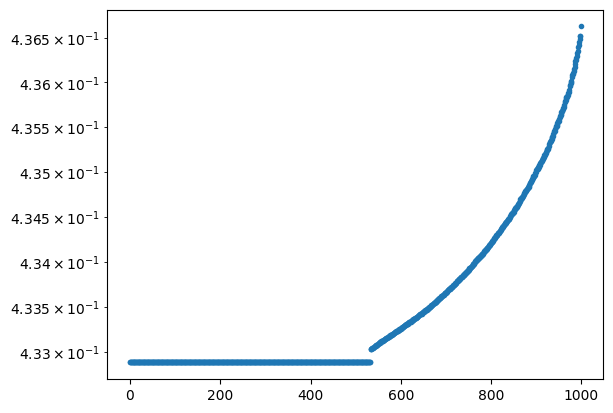

In [13]:
from kernel_layer import KernelMatrix
from kernel_layer import DenseNTK
import torch.nn as nn



def ffnn_model(D, K, M):
    # Initialize the layers list
    layers = []

    # Add the first layer with input size D and first hidden layer size M[0]
    layers.append(DenseNTK(D, M[0], activation=nn.ReLU(), bias=True))

    # Add the remaining hidden layers dynamically
    for i in range(1, len(M)):
        layers.append(DenseNTK(M[i-1], M[i], activation=nn.ReLU(), bias=True))

    # Add the final output layer with the last hidden layer size and output size K
    layers.append(DenseNTK(M[-1], K, activation=nn.Identity(), bias=True))

    # Create the model using nn.Sequential
    model = nn.Sequential(*layers)

    return model


D = x_vals.shape[0]
K = psi_vals.shape[0]
M = [1000]  # Number of nodes per hidden layer
NTK_ = KernelMatrix()
model = ffnn_model(D,K,M)
Df = NTK_.jacobian_torch(model, x_vals, show_progress=True)

kernel = torch.mm(Df,Df.T)
# eigenvalues are real (for the kernel matrix)
eig = torch.linalg.eigvals(kernel).real.to(dtype=torch.float32) 
eta = 1/(eig[1].item()) # 1/(lambda_max) 

plt.plot(torch.sort(eig)[0],'.')
plt.yscale('log')
plt.show()


## California House Price

In [14]:
import kernel_layer

from kernel_layer import KernelMatrix
from kernel_layer import DenseNTK
import torch.nn as nn



def ffnn_model(D, K, M):
    # Initialize the layers list
    layers = []

    # Add the first layer with input size D and first hidden layer size M[0]
    layers.append(DenseNTK(D, M[0], activation=nn.ReLU(), bias=True))

    # Add the remaining hidden layers dynamically
    for i in range(1, len(M)):
        layers.append(DenseNTK(M[i-1], M[i], activation=nn.ReLU(), bias=True))

    # Add the final output layer with the last hidden layer size and output size K
    layers.append(DenseNTK(M[-1], K, activation=nn.Identity(), bias=True))

    # Create the model using nn.Sequential
    model = nn.Sequential(*layers)

    return model



Computing Jacobian with Torch...


Jacobian computation: 100%|██████████| 4128/4128 [00:15<00:00, 266.04it/s]



Time taken: 15.564830541610718 seconds


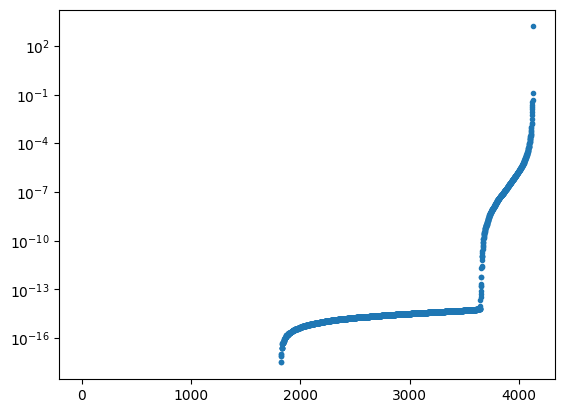

In [15]:
import torch
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Load the dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Step 2: Preprocess the data (optional but recommended)
# It's common to scale the input features before training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.80, random_state=42)

# Step 4: Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to match the output
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Check the tensor shapes
N = (X_train_tensor.shape[1])
D = (X_train_tensor.shape[1])  # e.g., torch.Size([16512, 8])
K = (y_train_tensor.shape[1])  # e.g., torch.Size([16512, 1])
M = [64,32,16]  # Number of nodes per hidden layer
NTK_ = KernelMatrix()
model = ffnn_model(D,K,M)
Df = NTK_.jacobian_torch(model, X_train_tensor, show_progress=True)
kernel = torch.mm(Df,Df.T)
eig = torch.linalg.eigvals(kernel).real.to(dtype=torch.float32) 
eta = 1/(eig[1].item()) # 1/(lambda_max) 

plt.plot(torch.sort(eig)[0],'.')
plt.yscale('log')
plt.show()